# Setting up `Python` 

The analysis presented in the manuscript and detailed next is carried
out with `Python 3` (the following code runs and gives identical results
with `Python 2`). We are going to use the 3 classical modules of
Python's scientific ecosystem: `numpy`, `scipy` and `matplotlib`. We are
also going to use two additional modules: `sympy` as well as `h5py`. We
start by importing these modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import scipy
import h5py

Python 2 users __must__ also type:
`from __future__ import print_function, division, unicode_literals, absolute_import`

# Getting the data


Our data ([Pouzat and Chaffiol,2015](https://zenodo.org/record/14281)) are stored in
[HDF5](http://www.hdfgroup.org/HDF5/) format on the
[zenodo](https://zenodo.org/) server (`DOI:10.5281/zenodo.1428145`).
They are all contained in a file named
`CockroachDataJNM_2009_181_119.h5`. The data within this file have an
hierarchical organization similar to the one of a file system (one of
the main ideas of the HDF5 format). The first organization level is the
experiment; there are 4 experiments in the file: `e060517`, `e060817`,
`e060824` and `e070528`. Each experiment is organized by neurons,
`Neuron1`, `Neuron2`, etc, (with a number of recorded neurons depending
on the experiment). Each neuron contains a `dataset` (in the HDF5
terminology) named `spont` containing the spike train of that neuron
recorded during a period of spontaneous activity. Each neuron also
contains one or several further sub-levels named after the odor used for
stimulation `citronellal`, `terpineol`, `mixture`, etc. Each a these
sub-levels contains as many `datasets`: `stim1`, `stim2`, etc, as
stimulations were applied; and each of these data sets contains the
spike train of that neuron for the corresponding stimulation. Another
`dataset`, named `stimOnset` containing the onset time of the stimulus
(for each of the stimulations). All these times are measured in seconds.

The data can be downloaded with `Python` as follows:

In [ ]:
try:
    from urllib.request import urlretrieve # Python 3
except ImportError:
    from urllib import urlretrieve # Python 2

name_on_disk = 'CockroachDataJNM_2009_181_119.h5'
urlretrieve('https://zenodo.org/record/14281/files/'+
            name_on_disk,
            name_on_disk)

The file is opened with:

In [2]:
f = h5py.File("CockroachDataJNM_2009_181_119.h5","r")

# Making the raster plots

We make our raster plots with a short function `raster_plot` that we define with:

In [3]:
def raster_plot(train_list,
                stim_onset=None,
                color = 'black'):
    """Create a raster plot.

    Parameters
    ----------
    train_list: a list of spike trains (1d vector with strictly
      increasing elements).
    stim_onst: a number giving the time of stimulus onset. If
      specificied, the time are realigned such that the stimulus
      comes at 0.
    color: the color of the ticks representing the spikes.

    Side effect:
    A raster plot is created.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    if stim_onset is None:
        stim_onset = 0
    for idx,trial in enumerate(train_list):
        plt.vlines(trial-stim_onset,
                   idx+0.6,idx+1.4,
                   color=color)
    plt.ylim(0.5,len(train_list))    

The raster plots of the responses of Neuron 1 to citronellal and terpineol are then obtained with:

/home/xtof/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


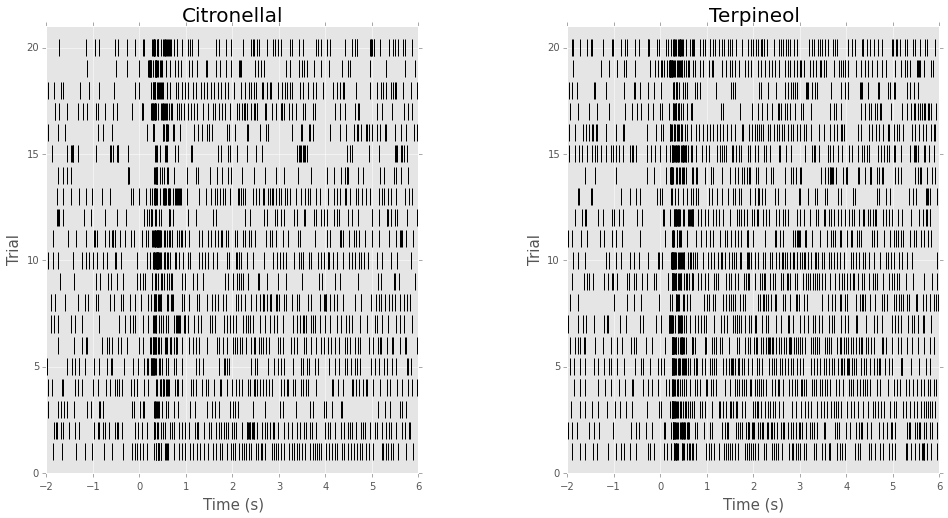

In [11]:
citron_onset = f["e060817/Neuron1/citronellal/stimOnset"][...][0]
e060817citron = [[f[y][...] for y in
                  ["e060817/Neuron"+str(i)+"/citronellal/stim"+str(x)
                   for x in range(1,21)]]
                 for i in range(1,4)]
fig = plt.figure(figsize=(16,8))
plt.subplot(121)
raster_plot(e060817citron[0],citron_onset)
plt.xlim(-2,6)
plt.ylim(0,21)
plt.grid(True)
plt.xlabel("Time (s)",fontdict={'fontsize':15})
plt.ylabel("Trial",fontdict={'fontsize':15})
plt.title("Citronellal",fontdict={'fontsize':20})
plt.subplot(122)
terpi_onset = f["e060817/Neuron1/terpineol/stimOnset"][...][0]
e060817terpi = [[f[y][...] for y in
                 ["e060817/Neuron"+str(i)+"/terpineol/stim"+str(x)
                  for x in range(1,21)]]
                for i in range(1,4)]
raster_plot(e060817terpi[0],terpi_onset)
plt.xlim(-2,6)
plt.ylim(0,21)
plt.grid(True)
plt.xlabel("Time (s)",fontdict={'fontsize':15})
plt.ylabel("Trial",fontdict={'fontsize':15})
plt.title("Terpineol",fontdict={'fontsize':20})
plt.subplots_adjust(wspace=0.4,hspace=0.4)

# Choosing the initial bin size

The bin width should be chosen large enough to have a few events per bin most of the time. We set this width such that an expected number of 3 events per bin was obtained using the spontaneous frequency estimated from 60 seconds long recordings without stimulus presentation—more specifically, the width was set to the smallest millisecond larger or equal to the targeted count divided by the product of the spontaneous frequency and the number of trials.

For the neurons of the data set we get the following spontaneous discharge rates:

In [12]:
e060817_spont_nu = [len(f["e060817/Neuron"+str(i)+"/spont"])/60
                    for i in range(1,4)] 
print("The spontaneous discharge rates are:")
for i in range(len(e060817_spont_nu)):
    print("  Neuron {0}: {1:.2f} (Hz)".format(i+1,e060817_spont_nu[i]))

The spontaneous discharge rates are:
  Neuron 1: 8.82 (Hz)
  Neuron 2: 20.48 (Hz)
  Neuron 3: 13.02 (Hz)


# Building the initial PSTH and stablizing them

For the citronellal response of Neuron 1 we do:

In [19]:
target_mean = 3
n_stim_citron = len(e060817citron[0])
n1citron = np.sort(np.concatenate(e060817citron[0]))
left = -5+citron_onset
right = 6+citron_onset
n1citron = n1citron[np.logical_and(left <= n1citron,n1citron <= right)]-citron_onset
bin_width_citron = np.ceil(target_mean/n_stim_citron/e060817_spont_nu[0]*1000)/1000
n1citron_bin = np.arange(-5,6+bin_width_citron,bin_width_citron)
n1citron_counts, n1citron_bin = np.histogram(n1citron,n1citron_bin)
n1citron_stab = 2*np.sqrt(n1citron_counts+0.25)
n1citron_x = n1citron_bin[:-1]+bin_width_citron/2

For the terpineol response we do:

In [20]:
n_stim_terpi = len(e060817terpi[0])
n1terpi = np.sort(np.concatenate(e060817terpi[0]))
left = -5+terpi_onset
right = 6+terpi_onset
n1terpi = n1terpi[np.logical_and(left <= n1terpi,n1terpi <= right)]-terpi_onset
bin_width_terpi = np.ceil(target_mean/n_stim_terpi/e060817_spont_nu[0]*1000)/1000
n1terpi_bin = np.arange(-5,6+bin_width_terpi,bin_width_terpi)
n1terpi_counts, n1terpi_bin = np.histogram(n1terpi,n1terpi_bin)
n1terpi_stab = 2*np.sqrt(n1terpi_counts+0.25)
n1terpi_x = n1terpi_bin[:-1]+bin_width_terpi/2

For the even and odd stimuli terpineol responses we do:

In [22]:
n1terpi_even = np.sort(np.concatenate(e060817terpi[0][0:20:2]))
n1terpi_even = n1terpi_even[np.logical_and(left <= n1terpi_even,n1terpi_even <= right)]-terpi_onset
bin_width_terpi_even = np.ceil(target_mean/n_stim_terpi/e060817_spont_nu[0]*1000)/1000/2
n1terpi_even_bin = np.arange(-5,6+bin_width_terpi_even,bin_width_terpi_even)
n1terpi_even_counts, n1terpi_even_bin = np.histogram(n1terpi_even,n1terpi_even_bin)
n1terpi_even_stab = 2*np.sqrt(n1terpi_even_counts+0.25)

n1terpi_odd = np.sort(np.concatenate(e060817terpi[0][1:20:2]))
n1terpi_odd = n1terpi_odd[np.logical_and(left <= n1terpi_odd,n1terpi_odd <= right)]-terpi_onset
bin_width_terpi_odd = np.ceil(target_mean/n_stim_terpi/e060817_spont_nu[0]*1000)/1000/2
n1terpi_odd_bin = np.arange(-5,6+bin_width_terpi_odd,bin_width_terpi_odd)
n1terpi_odd_counts, n1terpi_odd_bin = np.histogram(n1terpi_odd,n1terpi_odd_bin)
n1terpi_odd_stab = 2*np.sqrt(n1terpi_odd_counts+0.25)
n1terpi_odd_x = n1terpi_odd_bin[:-1]+bin_width_terpi_odd/2

We define two functions returning the boundaries:

In [24]:
def c95(x): return 0.299958+2.348443*np.sqrt(x)

def c99(x): return 0.312456+2.890606*np.sqrt(x)


We just have to make the graph after computing the `cumsum` of the differences:

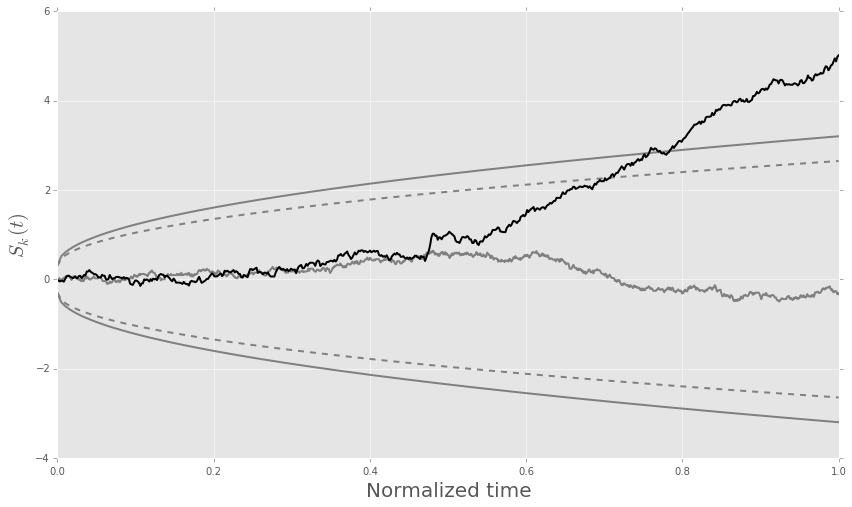

In [28]:
n1_diff_y = (n1terpi_stab-n1citron_stab)/np.sqrt(2)
X1 = np.arange(1,len(n1terpi_x)+1)/len(n1terpi_x)
Y1 = np.cumsum(n1_diff_y)/np.sqrt(len(n1_diff_y))
n1_diff_terpi_y = (n1terpi_even_stab-n1terpi_odd_stab)/np.sqrt(2)
X2 = np.arange(1,len(n1terpi_odd_x)+1)/len(n1terpi_odd_x)
Y2 = np.cumsum(n1_diff_terpi_y)/np.sqrt(len(n1_diff_terpi_y))  
xx = np.linspace(0,1,201)
fig = plt.figure(figsize=(14,8))
plt.plot(xx,c95(xx),color='grey',lw=2,linestyle='dashed')
plt.plot(xx,-c95(xx),color='grey',lw=2,linestyle='dashed')
plt.plot(xx,c99(xx),color='grey',lw=2)
plt.plot(xx,-c99(xx),color='grey',lw=2)
plt.plot(X2,Y2,color='grey',lw=2)
plt.plot(X1,Y1,color='black',lw=2)
plt.xlabel("Normalized time",fontdict={'fontsize':20})
plt.ylabel("$S_k(t)$",fontdict={'fontsize':20})

Before closing the session we close our file:

In [30]:
f.close()